In [1]:
# type: ignore

In [2]:
%matplotlib inline

# Reciever Design
The basis of the receiver design is currently around a Fred Harris band-edege filter design for frequency offset elimination and timing synchronization, since the modulation scheme is pi/4-dqpsk, recovering phase is not strictly necessary but further details regarding the demodulation aspect will be reveal as design progress 

This notebook contains the prototyping of the filtering and digital blocks that will be translated into the tetraphymac python module code and subsquent FPGA code

The structure will be as follows:
1. Halfband decimation filter of I, Q signal Q15 signal from x8 to x4
2. Channel select filter with high adjacent channel rejection >70dB
3. Channel-AGC
4. Complex mixing with signal from FLL NCO
5. Timing interpolator with signal from timing loop filter
6. Band edge (BE) branch off to FLL and timing synchronization
7. Decimation filter from x4 to x2
8. RRC filtering at x2 rate
9. Demodulation of dqpsk data

In [3]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import src.tetraphymac as tetra
import pm_remez

In [4]:
import src.tetraphymac.logical_channels as tetraLch
import src.tetraphymac.physical_channels as tetraPhy
import src.tetraphymac.transmitter as tetraTx
import src.tetraphymac.tx_rx_utilities as tetraUtil
import src.tetraphymac.constants as tetraConstants
import src.tetraphymac.measurements as tetraMeas

## Edge Band filter design

In [5]:
from numpy import pi, sin, cos, zeros, arange, float64, int64
def rrc_calculator(OSR:int, symbolSpan:int,beta:float=0.35):
    N = (symbolSpan * OSR) + 1
    n0 = (N-1)//2
    h = np.zeros(shape=N, dtype=float64)
    for n in range(N):
        tn = ((n-n0)/OSR)
        if np.isclose(tn, 0):
            h[n] = 1 - beta + ((4*beta)/pi)
        else:
            if np.isclose(tn, (1/(4*beta))) or np.isclose(tn,(-1/(4*beta))):
                h[n] = (beta/(2**(0.5)))*((1+(2/pi))*sin(pi/(4*beta)) + (1-(2/pi))*cos(pi/(4*beta)))
            else:
                h[n] = ((sin(pi*tn*(1-beta)))+(4*beta*tn*cos(pi*tn*(1+beta))))/(pi*tn*(1-((4*beta*tn)**2)))
    h /= h.sum(axis=0)
    return h

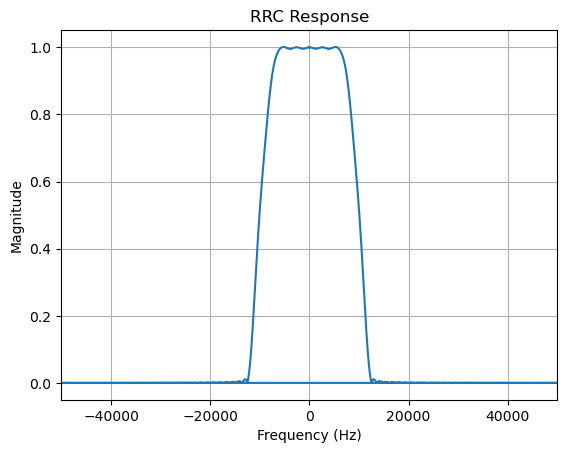

In [6]:
# rrc filter decimating 14 samples per symbol
# assume input sample rate is 8x
matched_filter = rrc_calculator(8, 14, 0.35)
from numpy.fft import fft, fftshift
sps = 8
fsym = 18000
Fs = (sps * fsym)  # sampling rate (Hz)
N_fft = 8192
H = sp.fft.fft(matched_filter, N_fft)
f = sp.fft.fftfreq(N_fft, d=1/Fs)

plt.figure()
plt.plot(f, np.abs(H))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("RRC Response")
plt.grid(True)
plt.xlim(-50e3, 50e3)
plt.show()

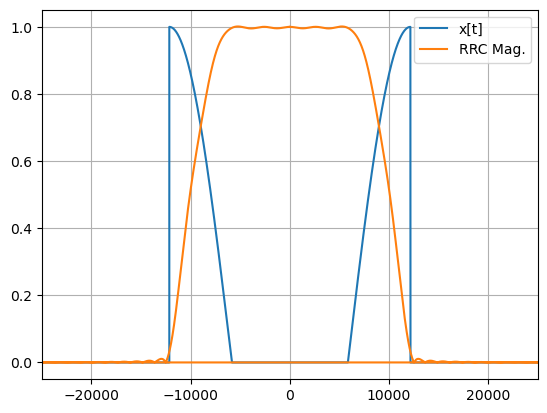

In [7]:
# halfband filters
a = 0.35
fsym = 18000

ch_spacing = 25000
# to reduce adj channel leakage affecting synchronization, ensure response goes to zero before end of roll off
# 1. [0->roll_off_edge_start]:0 (rigid) weight
# 2. [roll_off_edge_start->roll_off_edge_end]:ideal 3band-edge(cosine 1/2-cycle) (quasi rigid)
# 3. [roll_off_edge_end:roll_off_edge_end+700],->roll off don't care really (non-rigid)
# 4. [roll_off_edge_end+700: fs/2]:0 (rigid)


roll_off_edge_start = (fsym/2)*(1-a)
roll_off_edge_end = (fsym/2)*(1+a)

# The response is the d/dw of the rrc filter, which can be seen as just a cosine half-cycle that ends at
# at f = (fsym/2)*(1+a) and starts at (fsym/2)*(1-a) therefore the period is 4alpha*fs, the phase offset will be pi/2
# therefore using a sine is simplier to express, the anagular frequency can be expressed as 2pi/(ts) or pi/(2*alpha*fs)
def half_cosine(t):
    return sin((pi/(2*a*fsym))*(t-(roll_off_edge_start)))

def plot_ideal(f):
    resp  = []
    for fi in f:
        if np.abs(fi) < roll_off_edge_start:
            resp.append(0)
        elif roll_off_edge_start <= np.abs(fi) <= roll_off_edge_end:
            resp.append(half_cosine(np.abs(fi)))
        elif roll_off_edge_end < np.abs(fi):
            resp.append(0)
    return resp

H = sp.fft.fft(matched_filter, N_fft)
f = sp.fft.fftfreq(N_fft, d=1/Fs)
f2 = np.arange(-fsym*sps/2, fsym*sps/2, 1)
y = plot_ideal(f2)
plt.figure()
plt.plot(f2, y, label='x[t]')
plt.plot(f, np.abs(H), label='RRC Mag.')
plt.xlim(-25e3, 25e3)
plt.legend()
plt.grid(True)
plt.show()
H = np.fft.fftshift(H)

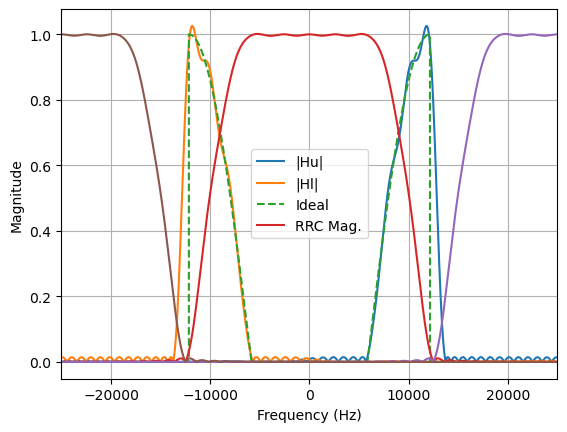

In [8]:
b = 0.35 # same as rolloff
fsym = 18000
sps = 8
fs = (fsym*sps)
start = (fsym/2)*(1-b)
end = (fsym/2)*(1+b)
width = end-start
cutoff = ((fsym/2)*(1+b))+1500

def half_cosine(t):
    return np.sin((pi/(2*b*fsym))*(t-(start)))
    
band_edges = [0, start, start, end, cutoff, fs/2]

weights = [2, 1, 2]
response = [0, half_cosine, 0]
design_even = pm_remez.remez(19*sps, band_edges, response, weight=weights, symmetry="even", fs=fs, maxiter=1000)
design_odd= pm_remez.remez(19*sps, band_edges, response, weight=weights, symmetry="odd", fs=fs, maxiter=1000)


edge_upper = 0.5*np.array(design_even.impulse_response) - 0.5j*np.array(design_odd.impulse_response)
edge_lower = 0.5*np.array(design_even.impulse_response) + 0.5j*np.array(design_odd.impulse_response)
f = np.fft.fftfreq(N_fft, d=1/fs)
Hu = np.fft.fftshift(np.fft.fft(edge_upper, N_fft))
Hl = np.fft.fftshift(np.fft.fft(edge_lower, N_fft))
f = np.fft.fftshift(f)

plt.figure()
plt.plot(f, np.abs(Hu), label="|Hu|")
plt.plot(f, np.abs(Hl), label="|Hl|")
plt.plot(f2, y, label='Ideal', linestyle="--")
plt.plot(f, np.abs(H), label='RRC Mag.')
plt.plot(f + 25e3, np.abs(H))
plt.plot(f - 25e3, np.abs(H))
plt.xlim(-fs/2, fs/2)
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(-25e3, 25e3)
plt.legend()
plt.show()

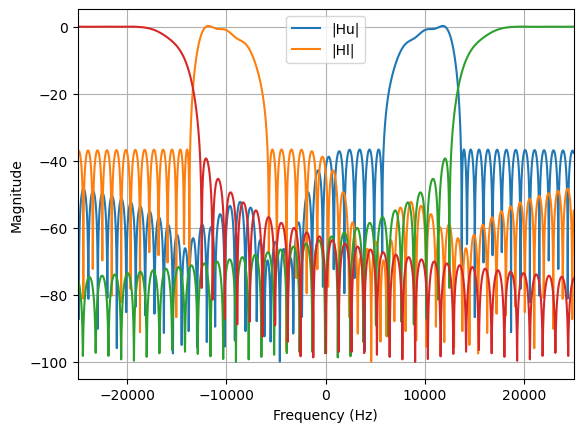

In [9]:
plt.figure()
plt.plot(f, 20*np.log10(np.abs(Hu) + 1e-5), label="|Hu|")
plt.plot(f, 20*np.log10(np.abs(Hl) + 1e-5), label="|Hl|")
#plt.plot(f2, 20*np.log10(np.abs(y) + 1e-5), label='x[t]')
# plt.plot(f, 20*np.log10(np.abs(H) + 1e-5), label='RRC Mag.')
plt.plot(f+25e3, 20*np.log10(np.abs(H) + 1e-5))
plt.plot(f-25e3, 20*np.log10(np.abs(H) + 1e-5))

plt.xlim(-fs/2, fs/2)
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(-25e3, 25e3)
plt.legend()
plt.show()

In [10]:
# Evaluate the performance versus frequency offset without adjacent channels
tx_real = tetraTx.RealTransmitter()
ul_tp_rf_channel = tetraPhy.PhysicalChannel(1, False, 905.1, 918.1, tetraPhy.PhyType.TRAFFIC_CHANNEL)
pkt_traffic_ch = tetraLch.TCH_4_8(n=1)
pkt_traffic_ch.encode_type5_bits(pkt_traffic_ch.generate_rnd_input(1))
ul_tp_burst = tetraPhy.NormalUplinkBurst(ul_tp_rf_channel, 1, 1, 1)
burst_modulation_bits = ul_tp_burst.construct_burst_sequence(pkt_traffic_ch)
tx_burst = tx_real.transmit_burst(burst_modulation_bits, (ul_tp_burst.start_ramp_period, ul_tp_burst.end_ramp_period))
# just focus on payload and not ramped portion
tx_burst = tx_burst[(ul_tp_burst.start_ramp_period-2)*64*10: -ul_tp_burst.end_ramp_period*10*64]
# Resample down to fsym x 8 to filter with edge filters
n_points = int(tx_burst.size / (80))
tx_burst_resamp = sp.signal.resample(tx_burst, n_points)



Pre x8 upsampling - symbol mapper  peakFS:  1.0 rmsFS:  0.9999998978888239
Post ramping  peakFS:  0.994121693553143 rmsFS:  0.6837062165035681


In [11]:
edge_upper_dc = edge_upper/np.abs(edge_upper)
edge_lower_dc = edge_lower/np.abs(edge_lower)

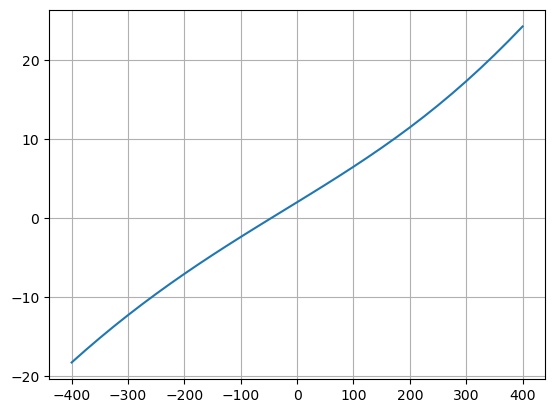

In [12]:
# We wish to evalate the result of the differences of power vs frequency offset
offsets = np.arange(-400, 400+25, 25)

def edge_filter_der(x, simplify:bool = False):
    upper_res = np.convolve(edge_upper_dc, x, mode="same")
    lower_res = np.convolve(edge_lower_dc, x, mode="same")
    sum_b = upper_res + lower_res
    dif_b = np.conjugate(upper_res - lower_res)
    return np.mean((sum_b*dif_b).real)

def freq_offset(x, f_offset):
    n = np.arange(x.size)
    return (x * np.exp(2*pi*1j*f_offset*n/fs))

vals = []            
for offset in offsets:
    x_u = freq_offset(tx_burst_resamp.copy(), float(offset))
    res = edge_filter_der(x_u)
    vals.append(res)

plt.figure()
plt.plot(offsets, vals)
plt.grid(True)
plt.show()


        

## NCO Design

In [13]:
# NCO design
# Recall fsamp = 114khz
fs = fsym*8
target_freq = 100
N = 24 # Phase accumulator bit depth
freq_res = fs / (1 << N)
del_phi = int((100 / fs)* (1 << N))
print(f"Freq res: {freq_res}, delta phi: {del_phi}")

Freq res: 0.00858306884765625, delta phi: 11650


In [14]:
M = 12  # Phase truncation bit width
L = (1 << M)
k = np.arange(L, dtype=np.float64)
# Map from k = 0 until k = pi/2
angle = (k / (L-1)) * (np.pi/2)
sin_lut = np.sin(angle)
sin_lut_quantized = np.round(sin_lut * (1 << 15)).astype(np.int64)

In [15]:
def sin_lut_lookup(phase, lut=sin_lut_quantized, N: int = 24, M: int = M):
    L = 1 << M  # The length of the lut as well
    assert L == lut.size
    # 2 MSB represent quadrant (because it is a 1/4
    quad = (phase >> (N-2)) & ((1 << 2)-1)
    p_index = (phase >> (N-2-M)) & ((1 << M)-1)

    match quad:
        case 0:
            val = lut[p_index]
        case 1:
            val = lut[(L-1) - p_index]
        case 2:
            val = -lut[p_index]
        case 3:
            val = -lut[(L-1) - p_index]
            
    return val.astype(int64)

def cos_lut_lookup(phase, lut=sin_lut_quantized, N: int = 24, M: int = M):
    new_phase = (phase + (1<<(N-2))) & ((1<<N)-1)  # Must add pi/2 offset, i.e. increment quadrant by 1
    return sin_lut_lookup(new_phase, lut, N, M)


    

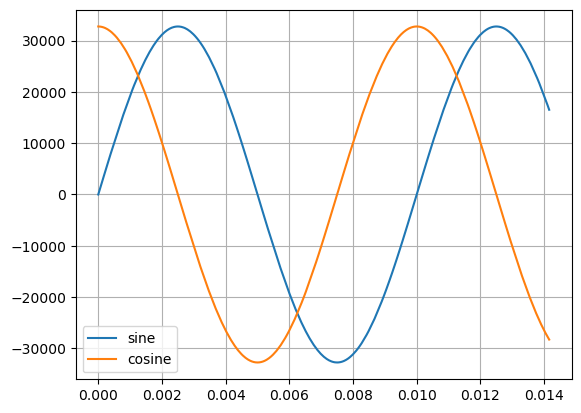

In [16]:
# Plot sine and cosine output
del_phi = int((100 / fs)* (1 << N))
#let it run for 2040 samples
phase = np.uint32(0)
cosine = np.zeros(2040, dtype=np.int64)
sine = np.zeros(2040, dtype=np.int64)

for k in range(2040):
    cosine[k] = cos_lut_lookup(phase)
    sine[k] = sin_lut_lookup(phase)
    phase = (phase + np.uint32(del_phi)) & ((1<<N)-1)

t = np.arange(0, (2040*(1/fs)), (1/fs))

plt.figure()
plt.plot(t, sine, label="sine")
plt.plot(t, cosine, label="cosine")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Complex mixing function
def complex_mixer(iq_data, freq_offset: int, N: int = 24, M: int = 12):
    # Calculate frequency word required
    del_phi = int((freq_offset / fs)* (1 << N))
    # Generate sine and cosine vector
    mix_t_len = iq_data.size
    phase = 0
    cosine = np.zeros(mix_t_len, dtype=np.float64)
    sine = np.zeros(mix_t_len, dtype=np.float64)

    for k in range(mix_t_len):
        cosine[k] = np.float64(cos_lut_lookup(phase)) / np.float64((1 << 15))
        sine[k] = np.float64(sin_lut_lookup(phase)) / np.float64((1 << 15))
        phase = (phase + del_phi) & ((1<<N)-1)

    temp_data = iq_data.copy()
    d_real = temp_data.real*cosine + temp_data.imag*sine
    d_imag = -temp_data.real*sine + temp_data.imag*cosine
    d_out = (d_real + 1j*d_imag).astype(np.complex128)
    
    return d_out
    

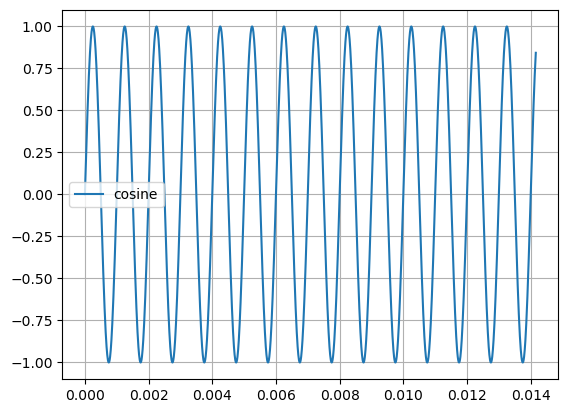

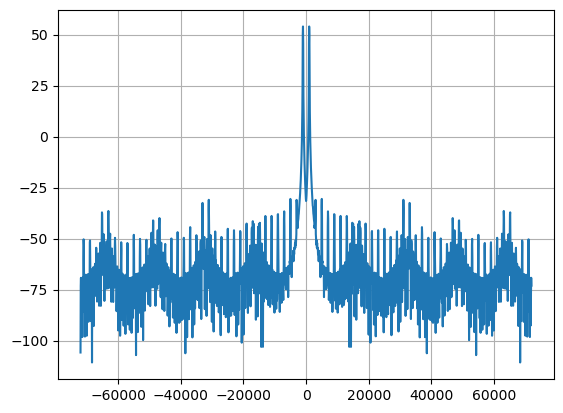

In [18]:
# Phase dithering, first generate plot of sfdr without dithering
fs = 18000 * 8
del_phi = int((1000 / fs)* (1 << N))
#let it run for 2040 samples
phase = np.uint32(0)
cosine = np.zeros(2040, dtype=np.float64)


for k in range(2040):
    cosine[k] = sin_lut_lookup(phase).astype(np.float64) / np.float64((1 << 15))
    phase = (phase + np.uint32(del_phi)) & ((1<<N)-1)

t = np.arange(0, (2040*(1/fs)), (1/fs))

plt.figure()
plt.plot(t, cosine, label="cosine")
plt.grid(True)
plt.legend()
plt.show()


ywindow = np.hanning(cosine.size)
xw = cosine * ywindow
yf = np.fft.fftshift(np.fft.fft(xw))
xf = np.fft.fftshift(np.fft.fftfreq(xw.size, (1/fs)))
yf = 20*np.log10(np.abs(yf) + 1e-12)

plt.plot(xf, yf)
plt.grid(True)
plt.show()

In [19]:
# want psuedorndm seq that does not repeat within N=8 interleaving, thus (255*8)*(8)=16,320, thus M=14 bits.
# Know maximum length sequence generator polynominal for M=14 is: x_14 + x_13 + x_12 + x_2 + 1

def lsfr_14(state: int):
    b2 = (state >> 1) & 1
    b12 = (state >> 11) & 1
    b13 = (state >> 12) & 1
    b14 = (state >> 13) & 1
    fb = b14 ^ b13 ^ b12 ^ b2
    state = (state << 1) | fb
    state &= ((1 << 14)-1)
    return state

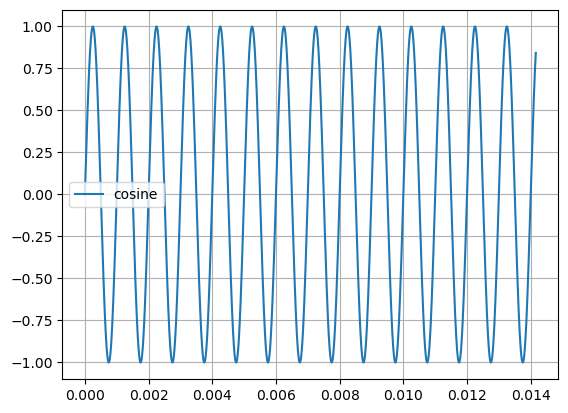

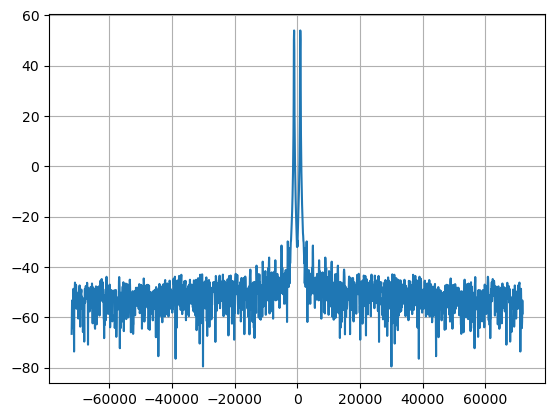

In [20]:
# apply phase dithering using triangluar dithering which is the difference of 
# Phase dithering, first generate plot of sfdr without dithering
fs = 18000 * 8
del_phi = int((1000 / fs)* (1 << N))
#let it run for 2040 samples
phase = int(0)
cosine = np.zeros(2040, dtype=np.float64)

lsfr1 = 0x1
lsfr2 = 0xAB2

for k in range(2040):
    lsfr1 = lsfr_14(lsfr1)
    pr_1 = lsfr1 & 0x3FF # Bottom 10 bits
    lsfr2 = lsfr_14(lsfr2)
    pr_2 = lsfr2 & 0x3FF # Bottom 10 bits

    dither = int(pr_1) - int(pr_2)
    phase_d = (phase + dither) & ((1<<N)-1)
    cosine[k] = sin_lut_lookup(phase_d).astype(np.float64) / np.float64((1 << 15))
    phase = (phase + del_phi) & ((1<<N)-1)

t = np.arange(0, (2040*(1/fs)), (1/fs))

plt.figure()
plt.plot(t, cosine, label="cosine")
plt.grid(True)
plt.legend()
plt.show()


ywindow = np.hanning(cosine.size)
xw = cosine * ywindow
yf = np.fft.fftshift(np.fft.fft(xw))
xf = np.fft.fftshift(np.fft.fftfreq(xw.size, (1/fs)))
yf = 20*np.log10(np.abs(yf) + 1e-12)

plt.plot(xf, yf)
plt.grid(True)
plt.show()

In [21]:
def complex_mixer_dither(iq_data, freq_offset: int, N: int = 24, M: int = 12):
    # Calculate frequency word required
    del_phi = int((freq_offset / fs)* (1 << N))
    # Generate sine and cosine vector
    mix_t_len = iq_data.size
    phase = 0
    cosine = np.zeros(mix_t_len, dtype=np.float64)
    sine = np.zeros(mix_t_len, dtype=np.float64)

    lsfr1 = 0x1
    lsfr2 = 0xAB2
    
    for k in range(mix_t_len):
        lsfr1 = lsfr_14(lsfr1)
        pr_1 = lsfr1 & 0x3FF # Bottom 10 bits
        lsfr2 = lsfr_14(lsfr2)
        pr_2 = lsfr2 & 0x3FF # Bottom 10 bits
    
        dither = int(pr_1) - int(pr_2)
        phase_d = (phase + dither) & ((1<<N)-1)
        cosine[k] = np.float64(cos_lut_lookup(phase_d)) / np.float64((1 << 15))
        sine[k] = np.float64(sin_lut_lookup(phase_d)) / np.float64((1 << 15))
        phase = (phase + del_phi) & ((1<<N)-1)

    temp_data = iq_data.copy()
    d_real = temp_data.real*cosine + temp_data.imag*sine
    d_imag = -temp_data.real*sine + temp_data.imag*cosine
    d_out = (d_real + 1j*d_imag).astype(np.complex128)
    
    return d_out

In [22]:
# Quantized loop calculations
edge_upper_q17_imag = (np.round(edge_upper_dc.imag.copy() * (1 << 17))).astype(np.int64)
edge_upper_q17_real = (np.round(edge_upper_dc.real.copy() * (1 << 17))).astype(np.int64)
edge_lower_q17_imag = (np.round(edge_lower_dc.imag.copy() * (1 << 17))).astype(np.int64)
edge_lower_q17_real = (np.round(edge_lower_dc.real.copy() * (1 << 17))).astype(np.int64)

## Initial decimation and channel select filter design

In [23]:
# Utility to generate input with adjacent channels, for now I'll assume two real adjacent channels
def freq_offset_w_carrier(x, f_offset, fs = (640 * 18000), fcarrier:float = 1000e3):
    n = np.arange(x.size)
    return np.real((x.copy() * np.exp(2*np.pi*1j*(fcarrier + f_offset)*n/fs)))

def complex_downconvert(x, fs = (640 * 18000), fcarrier:float = 1000e3):
    n = np.arange(x.size)
    return (x.copy() * np.exp(2*np.pi*-1j*(fcarrier)*n/fs))

def generate_input(freq_offset: int = 0, pwr_ratio_db: float = -40.0, adj_25: bool = True, adj_50: bool = True):
    tx_ideal = tetraTx.IdealTransmitter()
    pkt_traffic_ch = tetraLch.TCH_4_8(n=1)
    broad_cast_ch = tetraLch.AACH()
    tp_rf_channel = tetraPhy.PhysicalChannel(1, False, 905.1, 918.1, tetraPhy.PhyType.TRAFFIC_CHANNEL)

    offsets = [0.0]
    if adj_25:
        offsets.insert(0, -25e3)
        offsets.append(25e3)
    if adj_50:
        offsets.insert(0, -50e3)
        offsets.append(50e3)

    # Setup to generate burst data
    result_burst = None
    pkt_traffic_ch = tetraLch.TCH_4_8(n=1)
    broad_cast_ch = tetraLch.AACH()
    tp_rf_channel = tetraPhy.PhysicalChannel(1, False, 905.1, 918.1, tetraPhy.PhyType.TRAFFIC_CHANNEL)
    dl_tp_burst = tetraPhy.NormalDiscontDownlinkBurst(tp_rf_channel, 1, 1, 1)
    
    for ofst in offsets:
        pkt_traffic_ch = tetraLch.TCH_4_8(n=1)
        broad_cast_ch = tetraLch.AACH()
        pkt_traffic_ch.encode_type5_bits(pkt_traffic_ch.generate_rnd_input(1))
        broad_cast_ch.encode_type5_bits(broad_cast_ch.generate_rnd_input(1))
        dl_burst_bits = dl_tp_burst.construct_burst_sequence(pkt_traffic_ch, broad_cast_ch)
        dl_tx_burst = tx_ideal.transmit_burst(dl_burst_bits, (dl_tp_burst.start_ramp_period, dl_tp_burst.end_ramp_period))

        # Apply power scaling
        if ofst == 0.0:
            dl_tx_burst *= (10**(pwr_ratio_db/20))
        
        # Apply channel offsets/transmission
        actual_tx_burst = freq_offset_w_carrier(dl_tx_burst, ofst)

        if result_burst is None:
            result_burst = actual_tx_burst.copy()
        else:
            result_burst += actual_tx_burst.copy()
    # Down convert result back to DC via quadrature downconversion
    bb_rx_burst = complex_downconvert(result_burst.copy())

    # Perform LPF after filtering for the subsequent decimation
    lpf_taps = sp.signal.firwin(numtaps=231, cutoff=72E3, fs=(640*18000))

    bb_filt = sp.signal.lfilter(lpf_taps, 1.0, bb_rx_burst)

    bb_144k = sp.signal.resample_poly(bb_filt, up=1, down=80)
    # Rescale input to have ampltiude of 1
    bb_144k /= np.max(np.abs(bb_144k))

    # Quantize result in 16 bits
    bb_q15_real = (np.round(bb_144k.real.copy() * (1 << 15))).astype(np.int64)
    bb_q15_imag = (np.round(bb_144k.imag.copy() * (1 << 15))).astype(np.int64)
    
    return bb_q15_real, bb_q15_imag

In [24]:
# Design channel select filter
# first stage is x8 -> x4 decimate by 2 halfband filter
cutoff = 18_000 * 8 * 0.5
fs = 18000*8
h_halfband = sp.signal.firwin(39, fs/4, fs=fs)
for k in range(len(h_halfband)):
    if abs(h_halfband[k]) < 1e-6:
        h_halfband[k] = 0
print(h_halfband)

bands = [0, 0.22*fs, 0.28*fs, 0.5*fs]
alt_h_halfband = pm_remez.remez(39, bands, [1, 0], fs=fs).impulse_response
for k in range(len(alt_h_halfband)):
    if abs(alt_h_halfband[k]) < 1e-6:
        alt_h_halfband[k] = 0
print(alt_h_halfband)

[-0.00134197  0.          0.00196713  0.         -0.00376078  0.
  0.00707074  0.         -0.01237428  0.          0.02046831  0.
 -0.03300008  0.          0.05428087  0.         -0.10034927  0.
  0.31671864  0.50064139  0.31671864  0.         -0.10034927  0.
  0.05428087  0.         -0.03300008  0.          0.02046831  0.
 -0.01237428  0.          0.00707074  0.         -0.00376078  0.
  0.00196713  0.         -0.00134197]
[-0.004612057477274868, 0, 0.005309658869143398, 0, -0.008290917918256646, 0, 0.012370170123484984, 0, -0.017971669759902064, 0, 0.025875131997742315, 0, -0.03774743422814404, 0, 0.05795254806213175, 0, -0.1025987806352986, 0, 0.31712833195725065, 0.49999999999999906, 0.31712833195725065, 0, -0.1025987806352986, 0, 0.05795254806213175, 0, -0.03774743422814404, 0, 0.025875131997742315, 0, -0.017971669759902064, 0, 0.012370170123484984, 0, -0.008290917918256646, 0, 0.005309658869143398, 0, -0.004612057477274868]


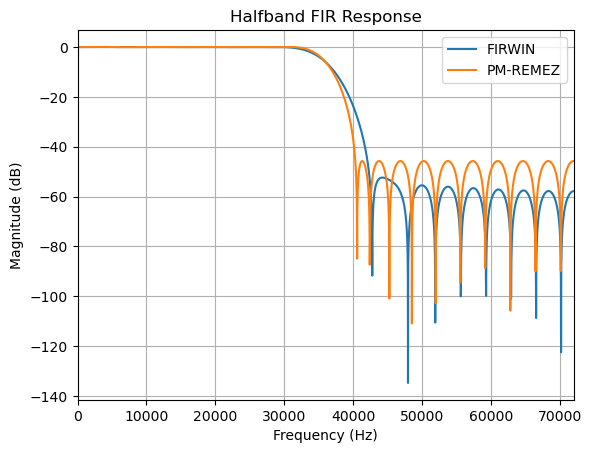

In [25]:
Fs = fs
N_fft = 8192
H = sp.fft.rfft(h_halfband, N_fft)
H2 = sp.fft.rfft(alt_h_halfband, N_fft)
f = sp.fft.rfftfreq(N_fft, d=1/Fs)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12), label="FIRWIN")
plt.plot(f, 20*np.log10(np.abs(H2) + 1e-12), label="PM-REMEZ")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Halfband FIR Response")
plt.legend()
plt.grid(True)
plt.xlim(0, Fs/2)
plt.show()

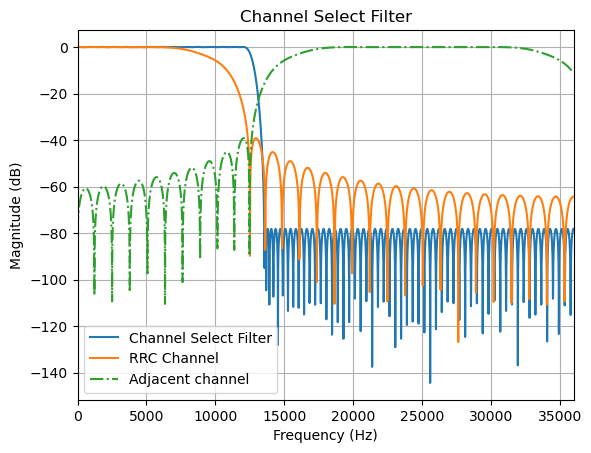

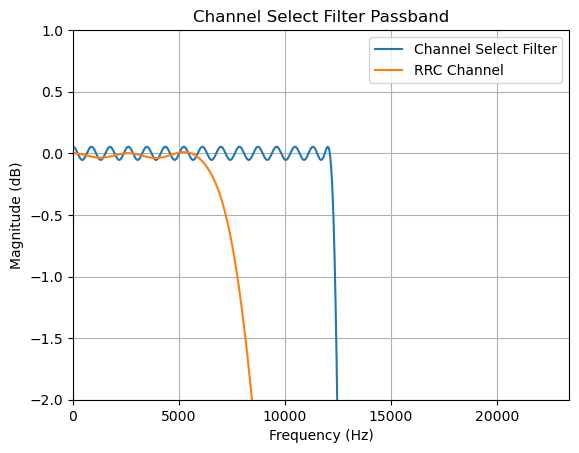

Preselect |H| @ 10.575k: 0.039057373383841895
Preselect |H| @ 12.150k: -0.05317552283073252
Preselect |H| @ 25k: -78.5931633159212
Preselect |H| @ 50k: -78.20184024355727


In [26]:
# Subsequent channel select filter, where high roll off is required
fs = 4 * 18_000

bands = [0, (18_000/2)*(1+.35), ((18_000/2)*(1+.35))+1400, 0.5*fs]

ch_select = pm_remez.remez(171, bands, [1, 0], weight=[1, 50], fs=fs).impulse_response
rrc = rrc_calculator(4, 14, 0.35)

Fs = fs
N_fft = 8192
H = np.fft.fftshift(np.fft.fft(ch_select, N_fft))
H2 = np.fft.fftshift(np.fft.fft(rrc, N_fft))
f = np.fft.fftshift(np.fft.fftfreq(N_fft, d=1/Fs))

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12), label="Channel Select Filter")
plt.plot(f, 20*np.log10(np.abs(H2)+ 1e-12), label="RRC Channel")
plt.plot(f+25e3, 20*np.log10(np.abs(H2)+ 1e-12), linestyle="-.", label="Adjacent channel")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Channel Select Filter")
plt.legend()
plt.grid(True)
plt.xlim(0, Fs/2)
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12), label="Channel Select Filter")
plt.plot(f, 20*np.log10(np.abs(H2)+ 1e-12), label="RRC Channel")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Channel Select Filter Passband")
plt.legend()
plt.grid(True)
plt.xlim(0, (fs/2)*(1-.35))
plt.ylim(-2, 1)
plt.show()

def mag_db_at(h, Fs, f_hz):
    w, H = sp.signal.freqz(h, worN=65536, fs=Fs)
    idx = np.argmin(np.abs(w - f_hz))
    return 20*np.log10(np.maximum(np.abs(H[idx]), 1e-14))

Fs = 72_000
# h = your 149-tap preselect
print("Preselect |H| @ 10.575k:", mag_db_at(ch_select, Fs, 10_575))
print("Preselect |H| @ 12.150k:", mag_db_at(ch_select, Fs, 12_150))
print("Preselect |H| @ 25k:",     mag_db_at(ch_select, Fs, 25_000))
print("Preselect |H| @ 50k:",     mag_db_at(ch_select, Fs, 50_000))

In [27]:
Fs = 72_000
bands = [0, 12_150, 13_550, Fs/2]

for Ws in [2, 5, 10, 20, 50]:
    h = pm_remez.remez(171, bands, [1, 0], weight=[1, Ws], fs=Fs).impulse_response
    a12 = mag_db_at(h, Fs, 12_150)
    a25 = mag_db_at(h, Fs, 25_000)
    a50 = mag_db_at(h, Fs, 50_000)
    print(Ws, " @12.15k", a12, " @25k", a25, " @50k", a50)

2  @12.15k -0.011888039489025701  @25k -63.600835286261706  @50k -63.20861036734627
5  @12.15k -0.01800308549918747  @25k -76.69278212270248  @50k -67.57274313031775
10  @12.15k -0.024556471454687638  @25k -72.06266019412779  @50k -70.90556733866693
20  @12.15k -0.03552582987139628  @25k -74.2172765865032  @50k -73.73093848253744
50  @12.15k -0.05317552283073252  @25k -78.5931633159212  @50k -78.20184024355727


## Channel AGC Design

In [28]:
# Following channel select filter we need basic digital AGC

## FLL Loop Design